In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

In [2]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
keras.__version__

'3.8.0'

#### BahdanauAttentionLSTM

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 40)     │      4,960 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 7, 40)     │      9,760 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 40)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 40),      │      1,661 │ lambda[0][0],     │
│ (BahdanauAttention) │ (None, 7, 1)]     │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        410 │ bahdanau_attenti… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,791 (65.59 KB)

 Trainable params: 16,791 (65.59 KB)

 Non-trainable params: 0 (0.00 B)

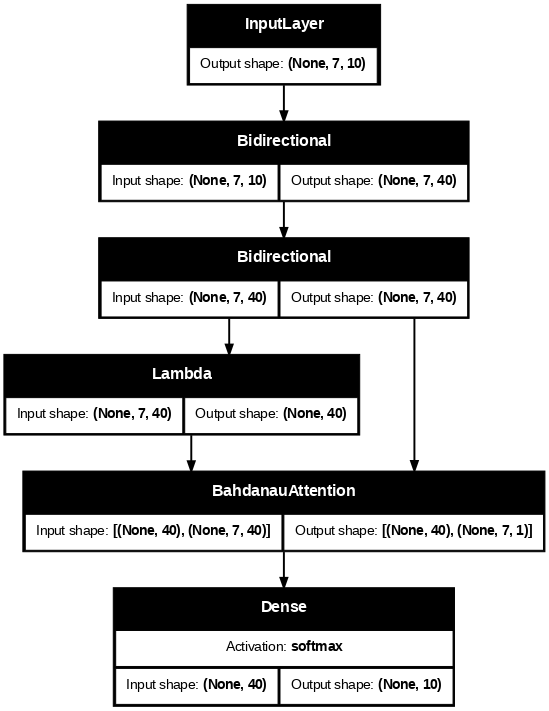

In [3]:
import tensorflow as tf
from keras import layers, Model, Input

# 모델 구성
units = 20
num_layers = 2

class BahdanauAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        """
        query: (bs, hidden_size), — 보통 마지막 타임스텝의 출력
        values: (batch_size, timesteps, hidden_size) — LSTM의 전체 시퀀스 출력
        """
        # query를 time 축으로 확장: (batch_size, 1, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)
        # score: (batch_size, timesteps, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        # attention_weights: (batch_size, timesteps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector: (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

inputs = Input(shape=(7, 10))
x = inputs
for _ in range(num_layers):
    x = layers.Bidirectional(       # x(bs, 7, 40)
            layers.LSTM(units, return_sequences=True, dropout=0.1))(x)

# query: 마지막 출력(batch_size, 40)
query = layers.Lambda(lambda t: t[:, -1, :])(x)

# Bahdanau Attention 적용
attention_layer = BahdanauAttention(units=units)
context_vector, attn_weights = attention_layer(query, x)

outputs = layers.Dense(10, activation='softmax')(context_vector)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
keras.utils.plot_model(model,show_shapes=True,show_layer_activations=True,dpi=70)

#### AttentionLSTM

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 7, 40)     │      4,960 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 7, 40)     │      9,760 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7, 1)      │         41 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 7, 1)      │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 40)     │          0 │ softmax[0][0],    │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 40)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │        410 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,171 (59.26 KB)

 Trainable params: 15,171 (59.26 KB)

 Non-trainable params: 0 (0.00 B)

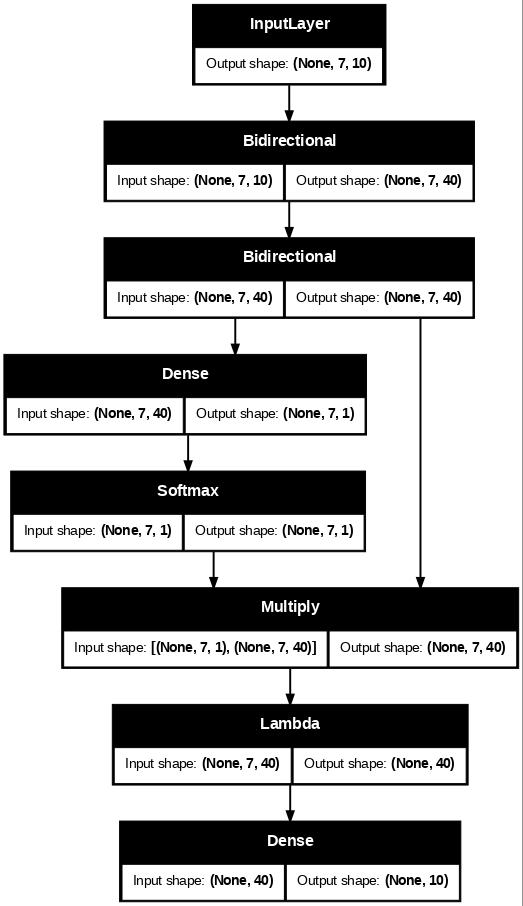

In [4]:
##### Attention LSTM #####
units = 20
num_layers = 2

inputs = layers.Input(shape=(7, 10))
x = inputs
for _ in range(num_layers):
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=0.1))(x)

# 각 타임스텝에 대해 attention score 계산 (Dense layer)
attn_scores = layers.Dense(1, activation='tanh')(x)

# 타임스텝(axis=1) 기준 softmax를 적용하여 attention 가중치 생성 (7,1)
attn_weights = layers.Softmax(axis=1)(attn_scores)

# 가중치 곱(Element-wise Multiplication)
# (7, 1) * (7, 40) --> (7,40)
# 브로드캐스팅(broadcasting)에 의해 (batch, 7, 40) 크기의 텐서가 됨
weighted_sequence = layers.Multiply()([attn_weights, x])

# 타임스텝 합산 (Summing over Timesteps)
# (7, 40) -> (40,)
context_vector = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(weighted_sequence)

# 최종 Fully Connected Layer
outputs = layers.Dense(10, activation='softmax')(context_vector)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
keras.utils.plot_model(model,'model.jpg',show_shapes=True,dpi=70)